# USABILITY TAGGER

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import sys
sys.path.append('../../utils')
import config_handling as conf
from database import Database
from file_io import path_handler
from cnn_helpers import preprocess_image, system_override

2025-01-29 23:50:30.828276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load configuration
config = conf.read_config('../../config/automotive.conf.ini')
config.read('config.ini')
connection_type = config['settings']['connection']
user = config[connection_type]['user']
pw = config[connection_type]['pw']
host = config[connection_type]['host']
db = config[connection_type]['db']
port = config[connection_type].getint('port')
db = Database(host,
              port,
              user,
              pw,
              db
              )
db.connect()

# Image directory
basedir = config['settings']['image_directory']

Connection established


## 1 Problem framing. 
Not all images are usefull to be part of the full classification pipeline, as such we want to get rid of these before we commence training. In some cases it's immediately apparent if an image is useful or not; pictures of keyfobs, tire thread, car seats... none of these help in the final goal of this project (i.e. identifying a car brand and model by exterior pictures. ) Some images clearly show the outside of a car, but show it in ways that'd not be helpful either: extreme close-ups or opened doors. These too are considered unusable. Finally there are photographs where the car is 'cropped' off to one or more sides. As a general rule these too will be flagged as unusable. 

## 2 Data.
No training data was available that could teach a model if an image is useful or not. To quickly generate this data, a Flask app was written which is part of this repo in `/flash angle tagger`. This tagger provides an HTML interface where crappy - vs non-crappy images could easily be marked by a click button or keyboard shortcut. If an image is considered to be usable, it'd receive one of eight possible angle-tags. The topic of angle tagging is discussed in notebook `2 - angle tagging.ipynb`. 

For an image to be considered usable, it had to fulfill the following requirements: 
1) The car should be fully visible on the image. (No cropping)
2) Obstruction is allowed, but should be kept within a reasonable amount. 
3) Doors, lids,... should be closed. 
4) Only exterior photographs are allowed. 

### 2.1 A sample of unusable images

In [3]:
def plot_images_as_grid(imseries, title, n=4): 
    """
    creates a grid of n*n images by randomply picking n**2 images
    from a series object (imseries) and plots them into the notebook. 
    """
    samplesize = n**2
    chosen = imseries.sample(samplesize)
    fig, axes = plt.subplots(n, n, figsize=(12, 12))
    axes = axes.flatten()
    i = 0
    for image in chosen: 
        img = Image.open(image)
        axes[i].imshow(img)
        axes[i].axis('off')
        i+=1
    fig.suptitle(title, fontsize=16)

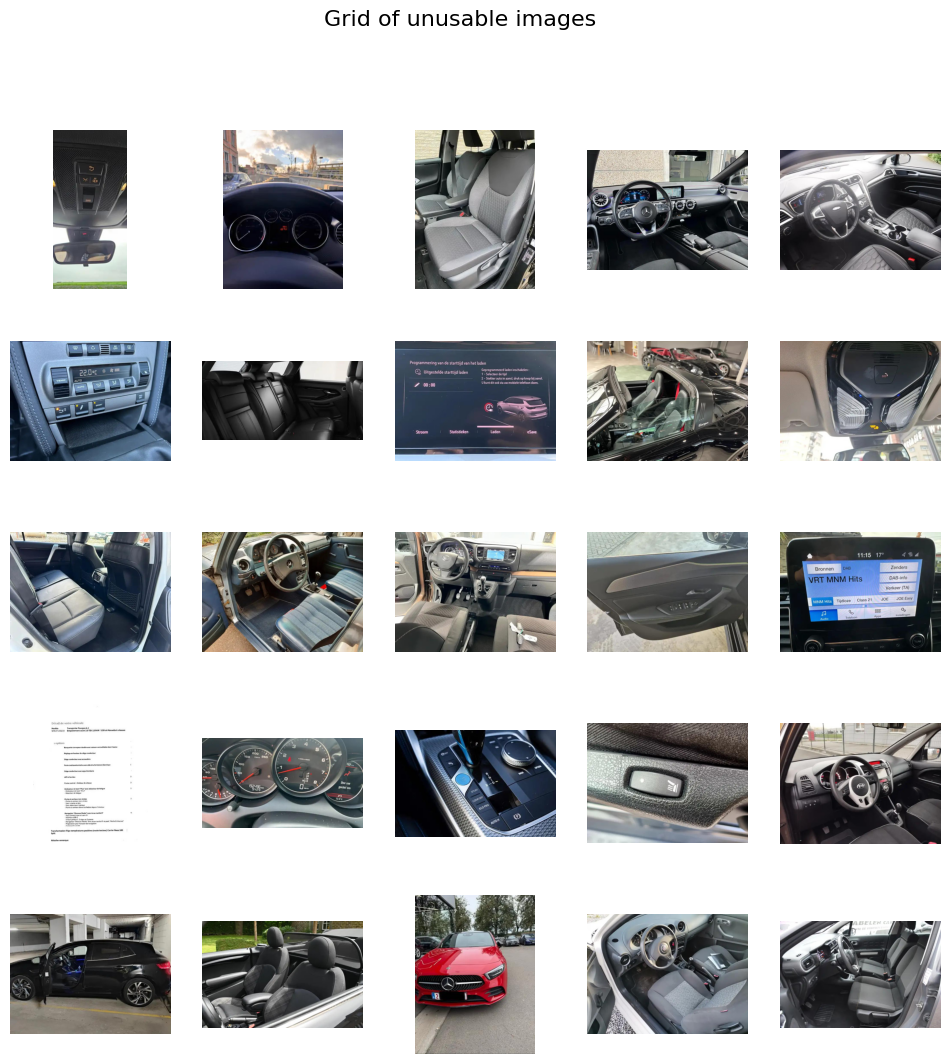

In [4]:
query = """ SELECT
                angletags.*,
                images.image_path
            FROM angletags 
            JOIN images ON images.id = angletags.image_id
            WHERE 
                angletags.manual_annotation = 1 AND
                angletags.angle = "crappy"; 
        """
unusable_data = db.execute_query(query)
crappy_df = pd.DataFrame(unusable_data)
crappy_df['image_path'] = crappy_df['image_path'].apply(lambda x: path_handler(basedir, x))
plot_images_as_grid(crappy_df['image_path'], 'Grid of unusable images', 5)

### 2.2 A sample of usable images

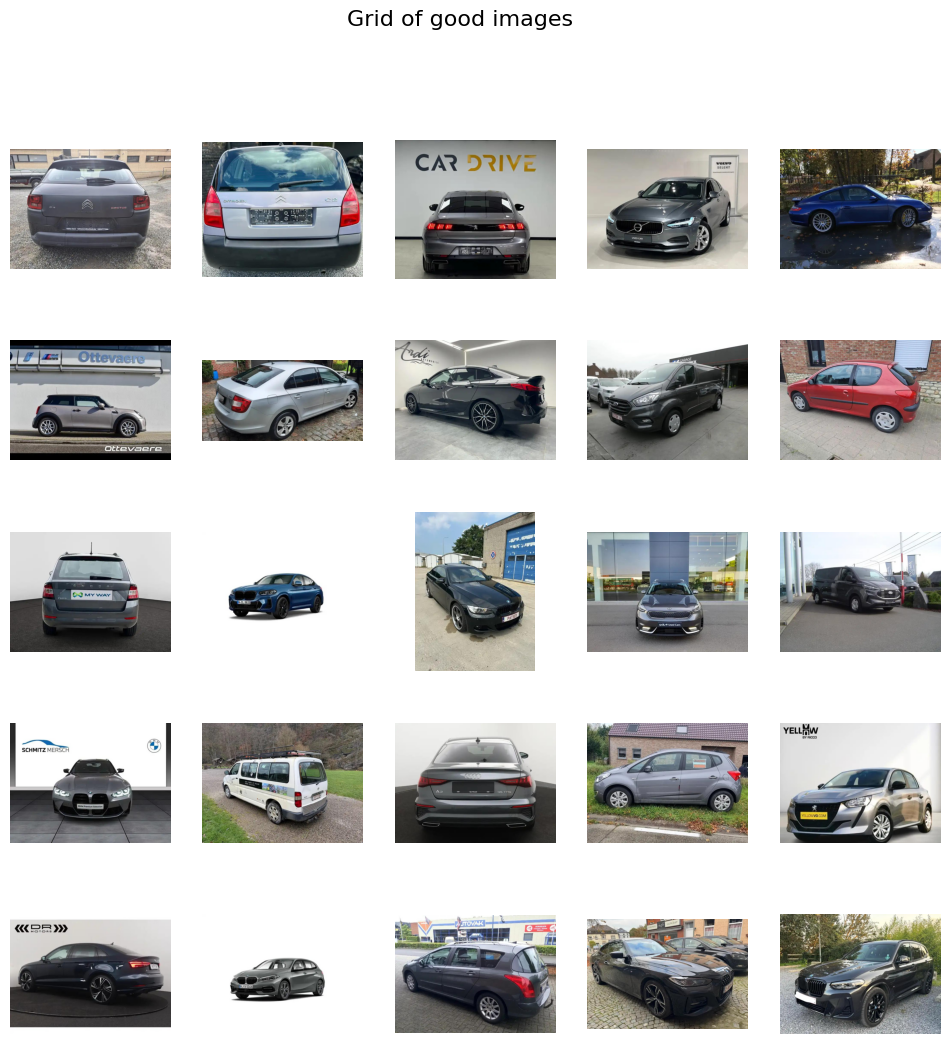

In [5]:
query = """ SELECT
                angletags.*,
                images.image_path
            FROM angletags 
            JOIN images ON images.id = angletags.image_id
            WHERE 
                angletags.manual_annotation = 1 AND
                angletags.angle <> "crappy"; 
        """
usable_data = db.execute_query(query)
good_df = pd.DataFrame(usable_data)
good_df['image_path'] = good_df['image_path'].apply(lambda x: path_handler(basedir, x))
plot_images_as_grid(good_df['image_path'], 'Grid of good images',5)

The two grids above of 5 by 5 each illustrate the outcome applying all rules. About 20.000 images where manually tagged. The outcome of this proces is as follows: 

Text(0.5, 1.0, 'Image usability of manually tagged data')

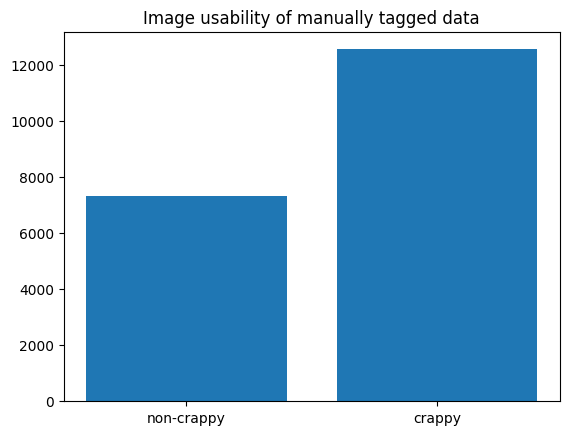

In [6]:
query = """SELECT
                COUNT(*) AS f,
                CASE
                    WHEN angletags.angle = 'crappy' THEN 'crappy'
                    ELSE 'non-crappy'
                END AS usability
            FROM angletags
            WHERE angletags.manual_annotation = 1
            GROUP BY usability
            HAVING usability IN ('crappy', 'non-crappy')
        """
angle_distribution_data = db.execute_query(query)
angle_df = pd.DataFrame(angle_distribution_data)
plt.bar(angle_df['usability'], angle_df['f'])
plt.title('Image usability of manually tagged data')

## 3. Model training: 
We do not know how many images we need to tag for a model to pick up the differences between a usable and unusable image. To figure this out, we'll go through our manually tagged data and gradually increase the amount of data our model is trained on. 

To do this, we'll start with splitting our data and keep a validation set to the side. This validation set will be used by every trained model to measure how well it performs. 

The part of the data that's not in the validation set will be used to train models, each model will see more data than the previous one. Our trainingsdata will start with seeing 5% of the data and grow with 5% increments each time. For every round of model training, we'll try to measure how precise the model is. We know that we've fed sufficient training data to our model if two consecutive training sets do not show any performance gain any longer. 

At this stage we also have our bounding boxes available, so we'll see if this makes the model perform better or not. 

In [7]:
system_override()

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    device = 'GPU'
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
else:
    device = 'CPU'

# Print the device being used
print(f"Using {device} for deep learning.")

System override applied - check if GPU is detected
Using GPU for deep learning.


2025-01-29 23:50:34.128237: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-29 23:50:36.425649: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-29 23:50:36.425723: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
# Get the data from MYSQL and into a pandas DataFrame: 
tagged_data_query = """ SELECT
                angletags.angle,
                images.image_path, 
                images.yolobox_top_left_x AS x1,
                images.yolobox_top_left_y AS y1,
                images.yolobox_bottom_right_x AS x2,
                images.yolobox_bottom_right_y AS y2
            FROM angletags 
            JOIN images ON images.id = angletags.image_id
            WHERE 
                angletags.manual_annotation = 1;
        """
tagged_usability_data = db.execute_query(tagged_data_query)
tagged_df = pd.DataFrame(tagged_usability_data)
#add the fully qualified paths: 
tagged_df['image_path'] = tagged_df['image_path'].apply(lambda x: path_handler(basedir, x))
#where no bounding box was made, the database holds NULL, (pandas NaN); 
# so fillna() with sentinel value
tagged_df = tagged_df.fillna(-1)
#enforce integers for bbox coords: 
tagged_df[['x1', 'y1', 'x2', 'y2']] = tagged_df[['x1', 'y1', 'x2', 'y2']].astype(int)
# encode an y:
tagged_df['usable_image'] = tagged_df['angle'].apply(lambda x: 0 if x == 'crappy' else 1)
# drop angle:
tagged_df.drop(columns=['angle'])



,image_path,x1,y1,x2,y2,usable_image
0,/home/frederic/Documents/automotive_image_data...,1,118,658,500,1
1,/home/frederic/Documents/automotive_image_data...,-1,-1,-1,-1,0
2,/home/frederic/Documents/automotive_image_data...,140,150,687,555,1
3,/home/frederic/Documents/automotive_image_data...,2,161,422,564,0
4,/home/frederic/Documents/automotive_image_data...,-1,-1,-1,-1,0
...,...,...,...,...,...,...
19855,/home/frederic/Documents/automotive_image_data...,-1,-1,-1,-1,0
19856,/home/frederic/Documents/automotive_image_data...,37,218,235,377,1
19857,/home/frederic/Documents/automotive_image_data...,-1,-1,-1,-1,0
19858,/home/frederic/Documents/automotive_image_data...,-1,-1,-1,-1,0


In [9]:
# Take a part of your data out to use as validation. Use a stratified split on the 'angle' column
#    YES... I know we already use angle, but it's not a problem; any angle that is not crappy is considered good.
#    so your stratified split woudl more or less be the same anyway. 
rs = 42
X = tagged_df.drop(columns=['usable_image'])
y = tagged_df['usable_image']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=tagged_df['angle'])

the X_validation and y_validation will not be used for training, only for evaluating every loop!

In [10]:
imsize_single_dim = 128    #how big is one side of the image. 
epochs = 10
batch_size = 32
model_dir = os.path.join(os.getcwd(), '../../models/bin_models')

In [11]:
os.makedirs(model_dir, exist_ok=True)

In [12]:
binary_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(imsize_single_dim, imsize_single_dim, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(imsize_single_dim, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(imsize_single_dim*2, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

binary_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/home/frederic/Documents/automotive_project/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-29 23:50:36.651716: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-29 23:50:36.651857: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-29 23:50:36.651927: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but ther

In [13]:
binary_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,529,601 (112.65 MB)

 Trainable params: 29,529,601 (112.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# start the experiment with data volume; also experiment with using or dismissing bounding boxes.
## TQDM is useless here, but this experiment should last: ((sum(fractions)/0.05) * 2) * first loop time 
# you could theoretically speed this up by not always resampling from X_train and y_train and just add 0.05 each time
# but I want to have the variety (in the small sample sises). 
fractions = np.linspace(0.05, 0.99999, 20)
fractions = [0.9999]
use_bboxes = [True, False]

for fraction in fractions:
    # Take fraction% of the data from X_train and y_train
    X_train_sample, _, y_train_sample, _ = train_test_split(
        X_train, y_train, 
        test_size=1-fraction,
        random_state=rs
    ) 
    for use_bounding_boxes in use_bboxes:
        name = f"fracsize={fraction}__bbox={use_bounding_boxes}__imsize_sqrd={imsize_single_dim}.keras"
        images = []
        for _, row in X_train_sample.iterrows():
            #print(row)
            bbox = (row['x1'], row['y1'], row['x2'], row['y2'])
            img = preprocess_image(row['image_path'], use_bounding_boxes, bbox, imsize_single_dim)
            images.append(img)
        images = np.array(images)  # you can't pass a list, but need to pass np array or a tensor!!: ((https://stackoverflow.com/questions/63527536/passing-a-python-list-to-keras-model-fit))
        y_train_sample = np.array(y_train_sample)  # just to be sure. 
        binary_model.fit(
                            images, 
                            y_train_sample, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_split=0.2
                        )
        saveto = os.path.join(model_dir, name)
        binary_model.save(saveto)
        with open(os.path.join(model_dir, 'model_notes.txt'), 'a+') as logfile: 
            logfile.write(f"{saveto}, {len(images)}, {epochs}, {imsize_single_dim}, {batch_size}\n")
            logfile.flush()





Epoch 1/10


I0000 00:00:1738191039.451429   32243 service.cc:146] XLA service 0x75c6a800c350 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738191039.451465   32243 service.cc:154]   StreamExecutor device (0): AMD Radeon RX 6700 XT, AMDGPU ISA version: gfx1030
2025-01-29 23:50:39.470437: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/20 ━━━━━━━━━━━━━━━━━━━━ 2:40 8s/step - accuracy: 0.5000 - loss: 0.6946

I0000 00:00:1738191047.083832   32243 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 687ms/step - accuracy: 0.5645 - loss: 1.6487 - val_accuracy: 0.6981 - val_loss: 0.5991
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6849 - loss: 0.5653 - val_accuracy: 0.7233 - val_loss: 0.4963
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8476 - loss: 0.3509 - val_accuracy: 0.8302 - val_loss: 0.3992
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9385 - loss: 0.1951 - val_accuracy: 0.8805 - val_loss: 0.3589
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9729 - loss: 0.1123 - val_accuracy: 0.8553 - val_loss: 0.3656
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9798 - loss: 0.0734 - val_accuracy: 0.8616 - val_loss: 0.4029
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9897 - loss: 0.0512 - val_accuracy: 0.8805 - val_loss: 0.4220
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9967 - loss: 0.0186 - val_accuracy: 0.8931 - val_loss: 

2025-01-30 00:26:32.975564: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1999110144 exceeds 10% of free system memory.
2025-01-30 00:26:34.556258: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1999110144 exceeds 10% of free system memory.


Epoch 1/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9868 - loss: 0.0558 - val_accuracy: 0.9748 - val_loss: 0.0959
Epoch 2/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9943 - loss: 0.0243 - val_accuracy: 0.9752 - val_loss: 0.1161
Epoch 3/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9983 - loss: 0.0065 - val_accuracy: 0.9732 - val_loss: 0.1637
Epoch 4/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9979 - loss: 0.0078 - val_accuracy: 0.9780 - val_loss: 0.1378
Epoch 5/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9975 - loss: 0.0099 - val_accuracy: 0.9792 - val_loss: 0.1651
Epoch 6/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9989 - loss: 0.0049 - val_accuracy: 0.9795 - val_loss: 0.1636
Epoch 7/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9986 - loss: 0.0037 - val_accuracy: 0.9788 - val_loss: 0.1412
Epoch 8/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9990 - loss: 0.0024 - val_ac

2025-01-30 00:28:14.902065: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1999110144 exceeds 10% of free system memory.
2025-01-30 00:28:16.355813: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1999110144 exceeds 10% of free system memory.


Epoch 1/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9913 - loss: 0.0385 - val_accuracy: 0.9607 - val_loss: 0.1335
Epoch 2/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9926 - loss: 0.0190 - val_accuracy: 0.9721 - val_loss: 0.1774
Epoch 3/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9961 - loss: 0.0113 - val_accuracy: 0.9673 - val_loss: 0.1705
Epoch 4/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9990 - loss: 0.0036 - val_accuracy: 0.9725 - val_loss: 0.2336
Epoch 5/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9987 - loss: 0.0033 - val_accuracy: 0.9752 - val_loss: 0.1368
Epoch 6/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9984 - loss: 0.0034 - val_accuracy: 0.9744 - val_loss: 0.1881
Epoch 7/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9984 - loss: 0.0028 - val_accuracy: 0.9717 - val_loss: 0.1924
Epoch 8/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9986 - loss: 0.0048 - val_accu

2025-01-30 00:29:50.240712: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2123956224 exceeds 10% of free system memory.


Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9900 - loss: 0.0448 - val_accuracy: 0.9778 - val_loss: 0.1314
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9942 - loss: 0.0183 - val_accuracy: 0.9782 - val_loss: 0.0960
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9972 - loss: 0.0084 - val_accuracy: 0.9726 - val_loss: 0.1241
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9954 - loss: 0.0168 - val_accuracy: 0.9756 - val_loss: 0.1286
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9977 - loss: 0.0059 - val_accuracy: 0.9782 - val_loss: 0.1147
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9982 - loss: 0.0064 - val_accuracy: 0.9785 - val_loss: 0.1219
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9796 - val_loss: 0.1511
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9984 - loss: 0.0040 - val_acc

In [23]:
images.shape

(794, 128, 128, 3)